### Phase 3 - Exploratory Data Analysis
    3.1 VADER Sentiment Analysis
    3.2 Word Count/Length Analysis
    3.3 Pipeline/Grid Search 
    3.4 Title Tags?  y/n?
        - Best of has common title tags (ie. LAOP)

3.0 - imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk

import spacy

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer


In [2]:
#load in clean data
df = pd.read_csv('./data/clean_reddit_data.csv')

In [3]:
df.describe()

,title,subreddit
count,10000,10000
unique,9889,2
top,Anti Aging Secrets,bestoflegaladvice
freq,4,5000


Okay, the dataframe looks the way I expect it to.  moving on.

## 3.1 VADER Sentiment Analysis

All right, let's see what I can find out using sentiment analysis, I'll look at polarity scores first.

In [4]:
sia = SentimentIntensityAnalyzer()
# following C. Schmitt's sentiment analysis lesson for SIA workflow.
# https://git.generalassemb.ly/DSI-12-Echelon/nlp_modeling_and_sentiment_analysis

dicts = []

for title in df['title']:
    scores = sia.polarity_scores(title)
    dicts.append(scores)

scores = pd.DataFrame(dicts)
scores.describe()

,neg,neu,pos,compound
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.115969,0.812754,0.071175,-0.103358
std,0.154780,0.186102,0.127707,0.384351
min,0.000000,0.000000,0.000000,-0.985500
25%,0.000000,0.705000,0.000000,-0.401900
50%,0.032000,0.834000,0.000000,0.000000
75%,0.196000,1.000000,0.111000,0.000000
max,1.000000,1.000000,1.000000,0.954400


Interesting!  Our neutral sentiment titles show a higher mean, and our compound score is slightly negative on average.  Time to drill down a bit deeper.

In [5]:
# add our scores to our exiting df
sia_df = pd.concat([df, scores], axis = 1)

SIA- Investigating Polarities

In [6]:
sia_df.sort_values(by='neg', ascending=False).head(20)

,title,subreddit,neg,neu,pos,compound
9183,Harassment,legaladvice,1.000,0.000,0.0,-0.5423
7957,Sick,legaladvice,1.000,0.000,0.0,-0.5106
6251,Twat,legaladvice,1.000,0.000,0.0,-0.6597
1233,WTF!,bestoflegaladvice,1.000,0.000,0.0,-0.6239
7042,Unemployment,legaladvice,1.000,0.000,0.0,-0.4404
9711,Serious Trouble,legaladvice,1.000,0.000,0.0,-0.4588
6688,Assault Victim,legaladvice,1.000,0.000,0.0,-0.7096
6981,Unfair delay??,legaladvice,1.000,0.000,0.0,-0.6966
8159,EvicTion,legaladvice,1.000,0.000,0.0,-0.4588
6828,Unemployment,legaladvice,1.000,0.000,0.0,-0.4404


In [7]:
sia_df.sort_values(by='pos', ascending=False).head(20)

,title,subreddit,neg,neu,pos,compound
933,Please help,bestoflegaladvice,0.0,0.000,1.000,0.6124
317,Ha,bestoflegaladvice,0.0,0.000,1.000,0.3400
7914,help,legaladvice,0.0,0.000,1.000,0.4019
4034,Please help,bestoflegaladvice,0.0,0.000,1.000,0.6124
727,Help,bestoflegaladvice,0.0,0.000,1.000,0.4019
9584,Please help,legaladvice,0.0,0.000,1.000,0.6124
8570,Please help,legaladvice,0.0,0.000,1.000,0.6124
9471,Intellectual,legaladvice,0.0,0.000,1.000,0.5106
155,help!!!,bestoflegaladvice,0.0,0.000,1.000,0.5538
8657,Help!,legaladvice,0.0,0.000,1.000,0.4574


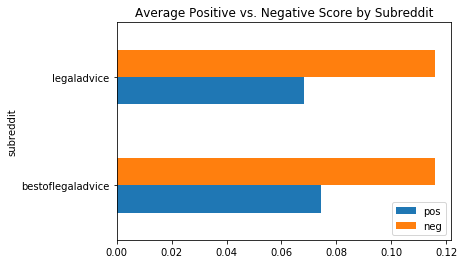

In [8]:
sia_df.groupby('subreddit').mean()[['pos', 'neg']].plot(kind='barh')
plt.title('Average Positive vs. Negative Score by Subreddit');

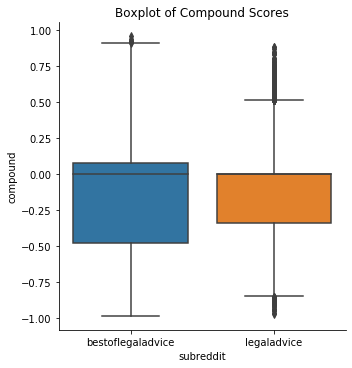

In [9]:
sns.catplot(x='subreddit', y='compound', kind='box', data=sia_df)
plt.title('Boxplot of Compound Scores');

The compound scores are showing the biggest variation between the two categories.  We're seeing a wider spread of compound sentiment scores in the r/bestoflegaladvice subreddit.

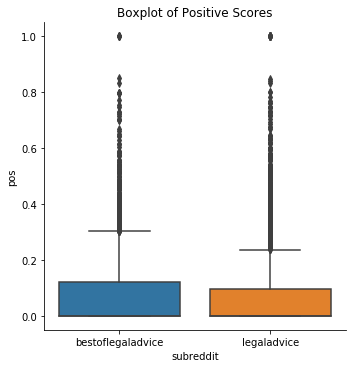

In [10]:
sns.catplot(x='subreddit', y='pos', kind='box', data=sia_df)
plt.title('Boxplot of Positive Scores');

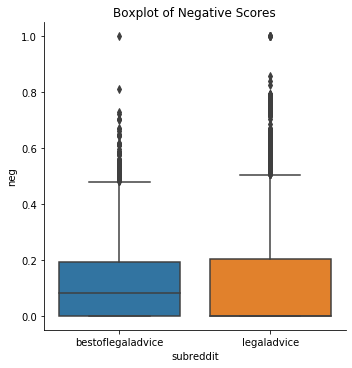

In [11]:
sns.catplot(x='subreddit', y='neg', kind='box', data=sia_df)
plt.title('Boxplot of Negative Scores');

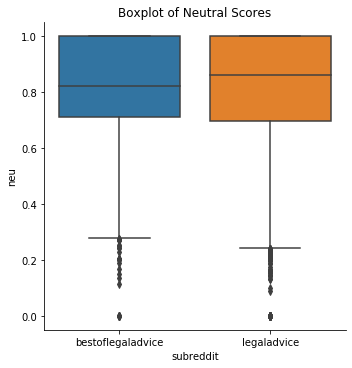

In [12]:
sns.catplot(x='subreddit', y='neu', kind='box', data=sia_df)
plt.title('Boxplot of Neutral Scores');

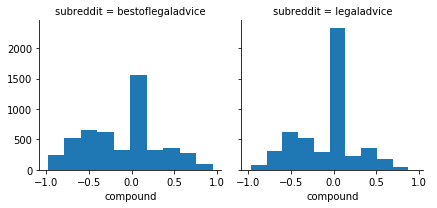

In [13]:
g = sns.FacetGrid(sia_df, col="subreddit")
g.map(plt.hist, "compound");
g.add_legend();

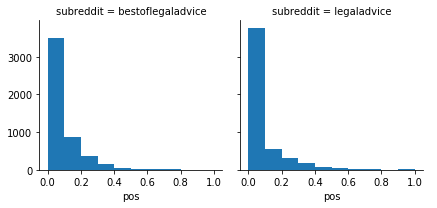

In [14]:
g = sns.FacetGrid(sia_df, col="subreddit")
g.map(plt.hist, "pos");
g.add_legend();

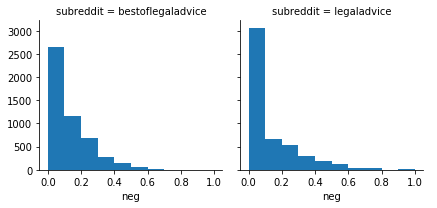

In [15]:
g = sns.FacetGrid(sia_df, col="subreddit")
g.map(plt.hist, "neg");
g.add_legend();

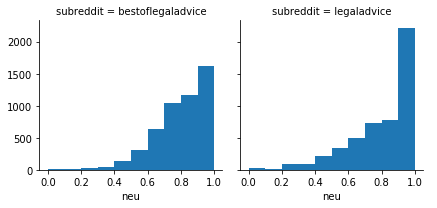

In [16]:
g = sns.FacetGrid(sia_df, col="subreddit")
g.map(plt.hist, "neu");
g.add_legend();

## 3.2 Word Count/Length Analysis with Count Vectorizer  (Bag-o-Words Style)


In [17]:
wc_df = sia_df.copy()

In [18]:
wc_df['char_count'] = wc_df['title'].map(len)

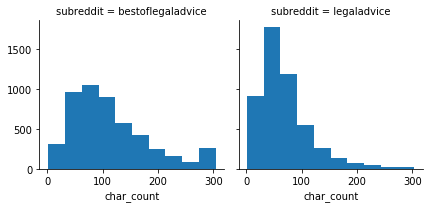

In [19]:
g = sns.FacetGrid(wc_df, col="subreddit")
g.map(plt.hist, "char_count")
g.add_legend();

Interesting- the overall length in characters of the r/bestoflegaladvice titles are showing a flatter curve and greater overall distribution than r/legaladvice, which is showing a positive skew.

In [20]:
wc_df.groupby('subreddit')['char_count'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
bestoflegaladvice,5000.0,113.5666,69.722612,2.0,62.0,97.5,148.0,304.0
legaladvice,5000.0,68.7170,46.230682,1.0,37.0,58.0,87.0,303.0


this is further shown by a higher mean and a higher mean and higher standard deviation

In [21]:
wc_df['word_count'] = [len(title.split(' ')) for title in wc_df['title']]

In [22]:
wc_df.groupby('subreddit')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
bestoflegaladvice,5000.0,20.0362,12.536169,1.0,11.0,17.0,26.0,64.0
legaladvice,5000.0,12.2516,8.754954,1.0,6.0,10.0,16.0,57.0


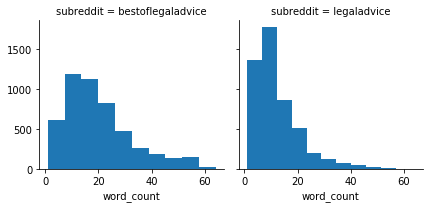

In [23]:
g = sns.FacetGrid(wc_df, col="subreddit")
g.map(plt.hist, "word_count")
g.add_legend();

Unsurprisingly, we're seeing comparable distributions of words counts to character counts.

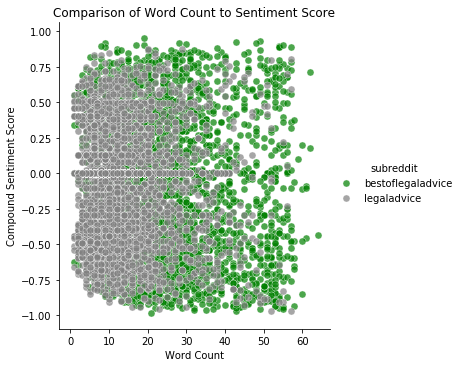

In [24]:
pal = dict(bestoflegaladvice="green", legaladvice="gray")
g = sns.FacetGrid(wc_df, hue="subreddit", palette=pal, height=5, )
g.map(plt.scatter, "word_count", "compound", s=50, alpha=.7, linewidth=.5, edgecolor="white")
plt.xlabel('Word Count')
plt.ylabel('Compound Sentiment Score')
plt.title('Comparison of Word Count to Sentiment Score')
g.add_legend();

In [25]:
# All right, we've generated a few more human-focused tables with this information, lets numerize it.
wc_df['target'] = wc_df['subreddit'].map({'bestoflegaladvice': 1, 'legaladvice': 0})

The following section uses functions created by Susan Li, available at her Towards Data Science post on NLP EDA
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [26]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [27]:
common_words = get_top_n_words(wc_df['title'], 50)
cw_df = pd.DataFrame(common_words, columns = ['Word', 'Count'])
cw_df[:20]

,Word,Count
0,laop,2729
1,legal,551
2,car,497
3,la,469
4,wants,454
5,landlord,427
6,title,416
7,advice,377
8,actual,351
9,help,348


In [28]:
cw_df = pd.DataFrame(common_words, columns = ['Word', 'Count'])

In [29]:
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english', ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [30]:
common_bigrams = get_top_n_bigrams(wc_df['title'], 20)

In [31]:
la_wc_df = wc_df[wc_df['subreddit'] == 'legaladvice'].copy()
bola_wc_df = wc_df[wc_df['subreddit'] == 'bestoflegaladvice'].copy()

In [32]:
la_common_bigrams = get_top_n_bigrams(la_wc_df['title'], 20)
bola_common_bigrams = get_top_n_bigrams(bola_wc_df['title'], 20)

In [33]:
la_cb_df = pd.DataFrame(la_common_bigrams, columns = ['Bigram', 'Count'])
la_cb_df

,Bigram,Count
0,need help,49
1,covid 19,47
2,need advice,31
3,legal advice,30
4,speeding ticket,29
5,child support,27
6,legal action,26
7,security deposit,25
8,small claims,23
9,don know,23


In [34]:
bola_cb_df = pd.DataFrame(bola_common_bigrams, columns = ['Bigram', 'Count'])
bola_cb_df

,Bigram,Count
0,actual title,315
1,laop wants,119
2,year old,99
3,wants know,68
4,legal advice,65
5,tree law,41
6,la discusses,40
7,laop gets,37
8,good advice,36
9,laop ex,36


All right!  We're seeing significant divergence here in the most common bigrams across the two subreddits.  This is promising for training a good model.  Additionally, we're seeing that the most common bigrams from r/bestoflegaladvice are much more common than r/legaladvice.  That being said, I'm seeing a very common tag popping up-  'LAOP'  In the context of r/bestoflegaladvice, this means 'Legal Advice Original Post'.  Additionally, the most common bigram overall is 'actual title'.  

While these two points are highly useful in building a classifier based on title alone, they might get in the way of longer term goals of building a predictor of which posts in r/legaladvice will become r/bestoflegaladvice.

## 3.3 Spacy library - Part of Speech Analysis

Inspired to use the Spacy Library by TowardsDataScience's post by Edward Ma available at https://towardsdatascience.com/named-entity-recognition-3fad3f53c91e

In [35]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
doc = nlp("This is a sentence.")
print([(w.text, w.pos_) for w in doc])

[('This', 'DET'), ('is', 'AUX'), ('a', 'DET'), ('sentence', 'NOUN'), ('.', 'PUNCT')]


In [36]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,token.shape_, token.is_alpha, token.is_stop)
len(doc)

This this DET DT nsubj Xxxx True True
is be AUX VBZ ROOT xx True True
a a DET DT det x True True
sentence sentence NOUN NN attr xxxx True False
. . PUNCT . punct . False False


5

In [37]:
pct_dicts = []
for title in df['title']:
    doc = nlp(title)
    typ_pcts = {
        'pct_nouns': (len([token.text for token in doc if token.pos_ == 'NOUN'])/ len(doc)),
        'pct_verbs' : (len([token.text for token in doc if token.pos_ == 'VERB'])/ len(doc)),
        'pct_propnouns' : (len([token.text for token in doc if token.pos_ == 'PROPN'])/ len(doc))
    }
    pct_dicts.append(typ_pcts)
    
pos_pcts = pd.DataFrame(pct_dicts)
pos_pcts.describe()
    

,pct_nouns,pct_verbs,pct_propnouns
count,10000.000000,10000.000000,10000.000000
mean,0.226342,0.136124,0.097478
std,0.145975,0.091894,0.151996
min,0.000000,0.000000,0.000000
25%,0.142857,0.083333,0.000000
50%,0.200000,0.133333,0.052632
75%,0.277778,0.185185,0.117647
max,1.000000,1.000000,1.000000


In [38]:
typ_dicts = []
for title in df['title']:
    doc = nlp(title)
    typ_counts = {
        'n_nouns': len([token.text for token in doc if token.pos_ == 'NOUN']),
        'n_verbs' : len([token.text for token in doc if token.pos_ == 'VERB']),
        'n_propnouns' : len([token.text for token in doc if token.pos_ == 'PROPN'])
    }
    typ_dicts.append(typ_counts)
    
pos_counts = pd.DataFrame(typ_dicts)
pos_counts.describe()

,n_nouns,n_verbs,n_propnouns
count,10000.000000,10000.000000,10000.000000
mean,3.815300,2.607900,1.367700
std,2.817549,2.248614,1.596544
min,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000
50%,3.000000,2.000000,1.000000
75%,5.000000,4.000000,2.000000
max,21.000000,15.000000,25.000000


In [39]:
ks_df = pd.concat([wc_df, pos_pcts, pos_counts], axis = 1) #Kitchen Sink Dataframe- it has everything in it.

In [40]:
ks_df.columns

Index(['title', 'subreddit', 'neg', 'neu', 'pos', 'compound', 'char_count',
       'word_count', 'target', 'pct_nouns', 'pct_verbs', 'pct_propnouns',
       'n_nouns', 'n_verbs', 'n_propnouns'],
      dtype='object')

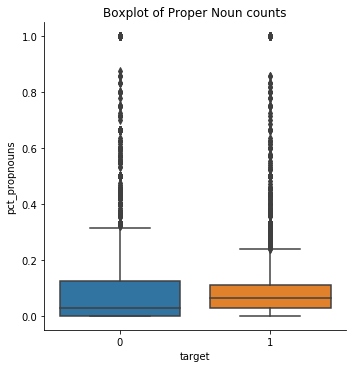

In [41]:
sns.catplot(x='target', y='pct_propnouns', kind = 'box', data= ks_df)
plt.title('Boxplot of Proper Noun counts');

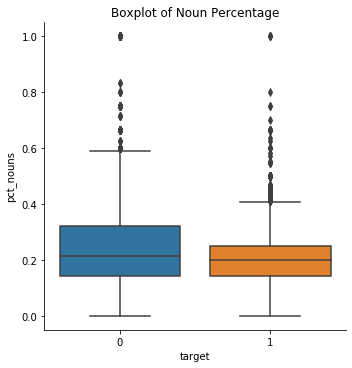

In [42]:
sns.catplot(x='target', y='pct_nouns', kind = 'box', data=ks_df)
plt.title('Boxplot of Noun Percentage');

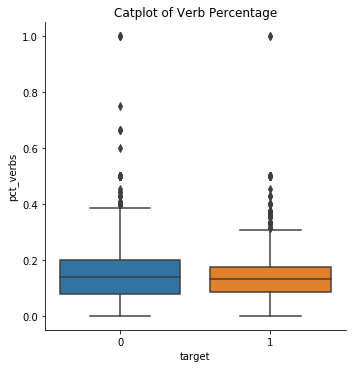

In [43]:
sns.catplot(x='target', y='pct_verbs', kind = 'box', data=ks_df)
plt.title('Catplot of Verb Percentage');

All right.  When plotting the percentage of part of speech type, I'm showing a few differences in spread between r/bestoflegaladvice and r/legaladvice.  Might be something to add in as an experiment for modeling the kitchen sink df in addition to a CountVectorized df or a TF-IDF Vectorized dataframe.  The documentation that is included with spaCy implies that is good for training Neural Network models and it might be a bit of a stretch to include it in this project.

I'll save the ks_df to .csv so I can experiment with training the model including what I've found here and move on to modeling.

In [44]:
ks_df.to_csv('./data/kitchen-sink-approach.csv', index= False)